In [1]:
%matplotlib inline

# Latest GEOS-16 satellite image

Python script to plot true color image from the GOES-16 (east; Atlantic) or GEOS-17 (west; Pacific) Advanced Baseline Imager (ABI) on a map.
Have a look at available satellite products here: https://thredds.ucar.edu/thredds/idd/satellite.html

NOAA provides the reflectance & brightness temperatures precomputed as the Level 2 (L2) product. Here, we are going to use to  ABI Cloud and Moisture Imagery for the CONUS (North America) region.

I followed the tutorial of Brian Blaylock found [here](https://github.com/blaylockbk/pyBKB_v2/blob/master/BB_goes16/mapping_GOES16_data.ipynb).

In [2]:
# =======
# import the libraries
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import patheffects
import matplotlib.pyplot as plt
import metpy  # noqa: F401
import numpy as np
from siphon.catalog import TDSCatalog
import xarray as xr
from xarray.backends import NetCDF4DataStore
from scipy import interpolate

In [81]:
%%time
# =======
# Get the most recent satellite image

def open_dataset(sector, date, channel, idx):
    """
    Open and return a netCDF Dataset object for a given sector, date, channel, and image index
    of GOES-16 data from THREDDS.
    """
    cat = TDSCatalog('https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/CloudAndMoistureImagery/'
             '{}/Channel{:02d}/{}/catalog.xml'.format(sector, channel, date)) #Mesoscale-1
    dataset = cat.datasets[idx]
    print(dataset.access_urls['OPENDAP'])
    ds = xr.open_dataset(dataset.access_urls['OPENDAP'])
    return ds

# define parameters
sector = 'CONUS'
date = datetime.strftime(datetime.utcnow(), '%Y%m%d') # last 2 weeks are stored
idx = -1    # most recent

# get Red (Band 2), Blue (Band 1) and Green (Band 3) as RGB and clean IR (Band 13) for nighttime
# I get sometimes Runtime Error "netCDF not found"--> loosing connection to Server

with open_dataset(sector, date, 1, idx) as blue_ds:
    blue_data = blue_ds['Sectorized_CMI'].data

with open_dataset(sector, date, 3, idx) as green_ds:
    green_data = green_ds['Sectorized_CMI'].data
    # Get projection and coordinates
    dat = green_ds.metpy.parse_cf('Sectorized_CMI')
    geos = dat.metpy.cartopy_crs
    x = green_ds['x'].data
    y = green_ds['y'].data
    
with open_dataset(sector, date, 2, idx) as red_ds:
    # Band 2 (Red Visible) has different resolution while Band 1 (Blue Visible) and Band 3 (Veggie IR) are 1000-meter resolution: Need to resample!
    #red_data = red_ds['Sectorized_CMI'].reindex(x=x, y=y, method='nearest')
    red_data = red_ds['Sectorized_CMI'].data
    x_red = red_ds['x'].data
    y_red = red_ds['y'].data

    
with open_dataset(sector, date, 13, idx) as cleanIR_ds:
    # Band 13 (IR) has different resolution while Band 1 (Blue Visible) and Band 3 (Veggie IR) are 1000-meter resolution: Need to resample!
    #cleanIR_data = cleanIR_ds['Sectorized_CMI'].reindex(x=x, y=y, method='nearest')
    cleanIR_data = cleanIR_ds['Sectorized_CMI'].data
    x_IR = cleanIR_ds['x'].data
    y_IR = cleanIR_ds['y'].data

# ======= Get Full Disk 
#cat = TDSCatalog('https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/CloudTopTemperature/FullDisk/current/catalog.xml')
#ds = scat.datasets[-1]
#print(ds)
#print(ds.access_urls)
#ds = ds.remote_access(use_xarray=True)

https://thredds.ucar.edu/thredds/dodsC/satellite/goes/east/products/CloudAndMoistureImagery/CONUS/Channel01/20200105/OR_ABI-L2-CMIPC-M6C01_G16_s20200050001180_e20200050001180_c20200050001180.nc
https://thredds.ucar.edu/thredds/dodsC/satellite/goes/east/products/CloudAndMoistureImagery/CONUS/Channel03/20200105/OR_ABI-L2-CMIPC-M6C03_G16_s20200050001180_e20200050001180_c20200050001180.nc
https://thredds.ucar.edu/thredds/dodsC/satellite/goes/east/products/CloudAndMoistureImagery/CONUS/Channel02/20200105/OR_ABI-L2-CMIPC-M6C02_G16_s20200050001180_e20200050001180_c20200050001180.nc
https://thredds.ucar.edu/thredds/dodsC/satellite/goes/east/products/CloudAndMoistureImagery/CONUS/Channel13/20200105/OR_ABI-L2-CMIPC-M6C13_G16_s20200050001180_e20200050001180_c20200050001180.nc
CPU times: user 6.85 s, sys: 3.12 s, total: 9.97 s
Wall time: 6min 40s


In [95]:
print(green_data.shape)
print(red_data.shape)
print(cleanIR_data.shape)
print(x.shape)
print(x_red.shape)
print(x_IR.shape)
print(y.shape)
print(y_red.shape)
print(y_IR.shape)

(3000, 5000)
(6000, 10000)
(1500, 2500)
(5000,)
(10000,)
(2500,)
(3000,)
(6000,)
(1500,)


In [103]:
print(x)
print(x_red)
print(x_IR)

<xarray.DataArray 'x' (x: 5000)>
array([-101346., -101318., -101290., ...,   38570.,   38598.,   38626.],
      dtype=float32)
Coordinates:
    time     datetime64[ns] ...
  * x        (x) float32 -101346.0 -101318.0 -101290.0 ... 38598.0 38626.0
Attributes:
    standard_name:  projection_x_coordinate
    units:          microradian
<xarray.DataArray 'x' (x: 10000)>
array([-101353., -101339., -101325., ...,   38605.,   38619.,   38633.],
      dtype=float32)
Coordinates:
    time     datetime64[ns] ...
  * x        (x) float32 -101353.0 -101339.0 -101325.0 ... 38619.0 38633.0
Attributes:
    standard_name:  projection_x_coordinate
    units:          microradian
<xarray.DataArray 'x' (x: 2500)>
array([-101332., -101276., -101220., ...,   38500.,   38556.,   38612.],
      dtype=float32)
Coordinates:
    time     datetime64[ns] ...
  * x        (x) float32 -101332.0 -101276.0 -101220.0 ... 38556.0 38612.0
Attributes:
    standard_name:  projection_x_coordinate
    units:          micror

In [100]:
# =======
# remapping Band 2 and Band 13

# Band 2 (Red Visible) is 500-meter resolution while Band 1 (Blue Visible) and Band 3 (Veggie IR) are 1,000-meter resolution. In order to combine the 3 bands into an RGB image we will first resample bands 2 to 1000-meter resolution.

def interpolate_channel(data, x_old, y_old, x_new, y_new):
    """
    Interpolate the channel to the same grid as another channel.
    """
    
    # new grid
    X_new, Y_new = np.meshgrid(x_new, y_new[::-1])
    newpoints = np.array((X_new, Y_new)).T
    
    f = interpolate.RegularGridInterpolator((x_old, y_old[::-1]), data.T)

    data_new = f(newpoints).T
    
    return data_new


red_new = interpolate_channel(red_data, x_red, y_red, x, y)
#cleanIR_new = interpolate_channel(cleanIR_data, x_IR, y_IR, x, y)

In [131]:
def regrid(data, in_x, in_y, out_x, out_y):   
    
    #correct first and last entry so that not out of bounds
    out_x[0] = in_x[0]; out_x[-1] = in_x[-1]
    out_y[0] = in_y[0]; out_y[-1] = in_y[-1]
    
    interpolating_function = interpolate.RegularGridInterpolator((in_y[::-1], in_x), data)
    yv, xv = np.meshgrid(out_x, out_y[::-1])
    return interpolating_function((xv, yv))

red_new = regrid(red_data, x_red.data, y_red.data, x.data, y.data)
cleanIR_new = regrid(cleanIR_data, x_IR.data, y_IR.data, x.data, y.data)

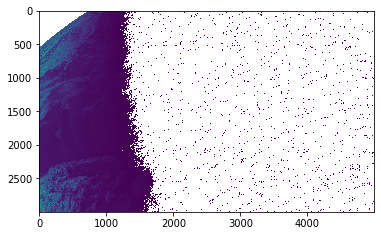

In [132]:
plt.imshow(red_new)

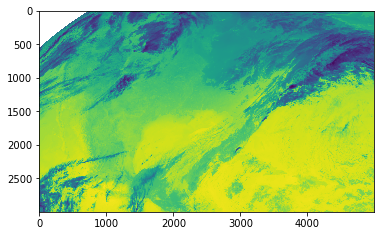

In [133]:
plt.imshow(cleanIR_new)

In [159]:
# =====
# prepare True color image

# Apply range limits for each channel. RGB values must be between 0 and 1
#red = np.clip(red_new, 0, 1)
#green = np.clip(green_data, 0, 1)
#blue = np.clip(blue_data, 0, 1)

red = np.maximum(red_new, 0)
green = np.maximum(green_data, 0)
B = np.maximum(blue_data, 0)

red = np.minimum(red, 1)
green = np.minimum(green, 1)
blue = np.minimum(blue, 1)

# Apply a gamma correction to the image to correct ABI detector brightness
gamma = 0.4
red = np.power(red, gamma)
green = np.power(green, gamma)
blue = np.power(blue, gamma)

green_true = 0.48358168 * red + 0.45706946 * blue + 0.06038137 * green
green_true = np.maximum(green_true, 0)
green_true = np.minimum(green_true, 1)

# The RGB array with the raw veggie band
RGB_veggie = np.dstack([red, green_true, blue])    # The addition of the three channels results in a color image.

# =======
# prepare nighttime IR when dark

# Apply range limits for clean IR channel
#cleanIR = np.clip(cleanIR_new, 90, 313)

cleanIR = np.maximum(cleanIR_new, 90)
cleanIR = np.minimum(cleanIR, 313)

# Normalize the channel between a range
cleanIR = (cleanIR-90)/(313-90)

# Invert colors so that cold clouds are white
cleanIR = 1 - cleanIR

# Lessen the brightness of the coldest clouds so they don't appear so bright when we overlay it on the true color image
cleanIR = cleanIR/1.4

RGB_cleanIR = np.dstack([cleanIR, cleanIR, cleanIR])

# Maximize the RGB values between the True Color Image and Clean IR image
RGB_ColorIR = np.dstack([np.maximum(red, cleanIR), np.maximum(green, cleanIR),
                         np.maximum(blue, cleanIR)])

In [157]:
np.nanmax(RGB_veggie)

0.9362285137176514

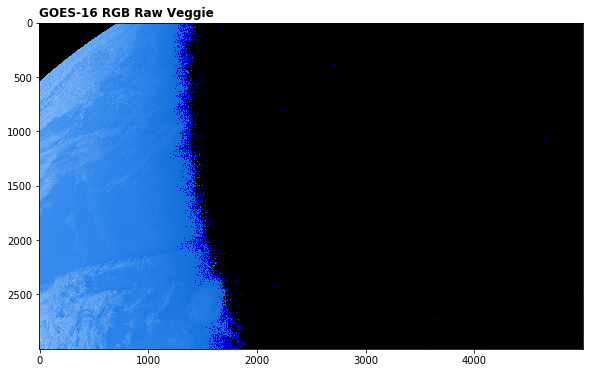

In [160]:
fig, ax1 = plt.subplots(1,1, figsize=(16,6))

# The RGB using the raw veggie band
ax1.imshow(RGB_veggie)
ax1.set_title('GOES-16 RGB Raw Veggie', fontweight='semibold', loc='left', fontsize=12);

In [39]:
# Get projection from satellite data
dat = ds.metpy.parse_cf('Rad')
geos = dat.metpy.cartopy_crs

# Get coordinaates: x (north/south) and y (east/west) axis sweep of the ABI data
x = dat.x
y = dat.y

# Grab time from file and convert to a nice format
vtime=datetime.strptime(ds.time_coverage_end,'%Y-%m-%dT%H:%M:%S.%fZ')

In [42]:
# Get Visible data, convert to reflectance factor and apply gamma correction
# read in the radiance variable, called ‘Rad’
vis=np.sqrt(ds.Rad*ds.kappa0)

/home/steidani/miniconda3/envs/weather_2019/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  


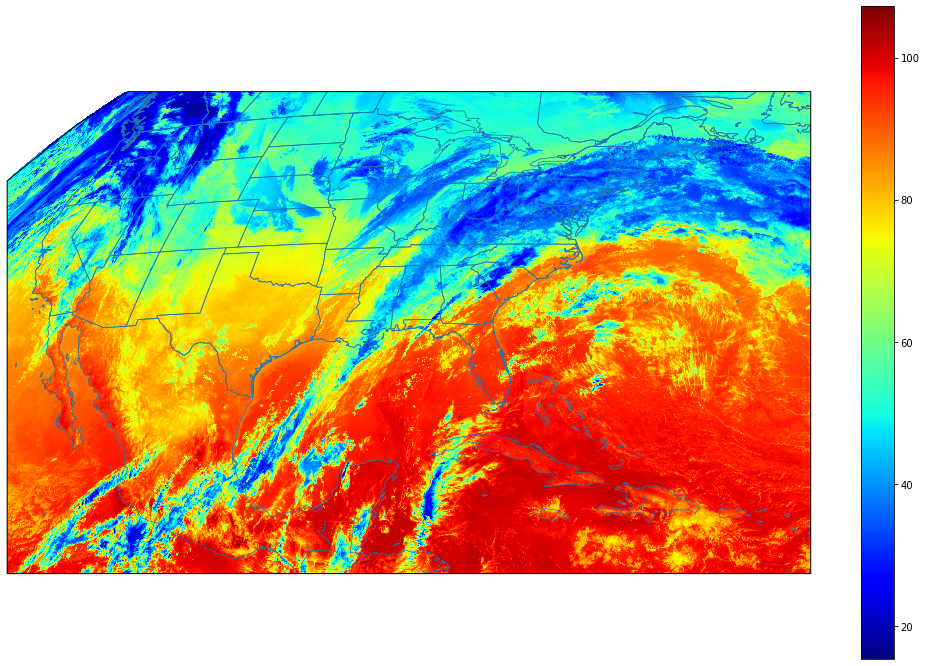

In [45]:
# Start figure and set up projection on axes for plotting
fig=plt.figure(1,figsize=(18,12))
ax=plt.subplot(111,projection=geos)

# Plot geopolitical lines
ax.add_feature(cfeature.COASTLINE.with_scale('50m'),edgecolor='tab:blue',linewidths=0.75)
ax.add_feature(cfeature.BORDERS.with_scale('50m'),edgecolor='tab:blue',linewidths=0.75)
ax.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='tab:blue',linewidths=0.75)

# Plot gamma correction visible reflectance values
im = ax.imshow(vis,extent=(x.min(),x.max(),y.min(),y.max()),origin='upper',cmap=plt.cm.Greys_r)
plt.colorbar(im)

plt.tight_layout()
plt.show()